In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import geopandas as gpd
cwd = os.getcwd()
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('mode.chained_assignment', None) # Deshabilita SettingWithCopyWarning. Ojo.

In [2]:
df = pd.read_csv(cwd+"/train.csv", index_col='id', parse_dates=['fecha'])

In [3]:
"UNIFICO ALGUNOS VALORES"
df.loc[df['tipodepropiedad'] == 'Casa uso de suelo', 'tipodepropiedad'] = 'Casa'
df.loc[df['tipodepropiedad'] == 'Departamento Compartido', 'tipodepropiedad'] = 'Departamento'
df.loc[df['tipodepropiedad'] == 'Apartamento', 'tipodepropiedad'] = 'Departamento'
df.loc[df['tipodepropiedad'] == 'Edificio', 'tipodepropiedad'] = 'Departamento'
df.loc[df['tipodepropiedad'] == 'Local Comercial', 'tipodepropiedad'] = 'Oficina comercial'
df.loc[df['tipodepropiedad'] == 'Bodega comercial', 'tipodepropiedad'] = 'Oficina comercial'
df.loc[df['tipodepropiedad'] == 'Terreno comercial', 'tipodepropiedad'] = 'Oficina comercial'
df.loc[df['tipodepropiedad'] == 'Oficina Comercial', 'tipodepropiedad'] = 'Oficina comercial'
df.loc[df['tipodepropiedad'] == 'Local en centro comercial', 'tipodepropiedad'] = 'Oficina comercial'
df.loc[df['tipodepropiedad'] == 'Nave industrial', 'tipodepropiedad'] = 'Terreno industrial'

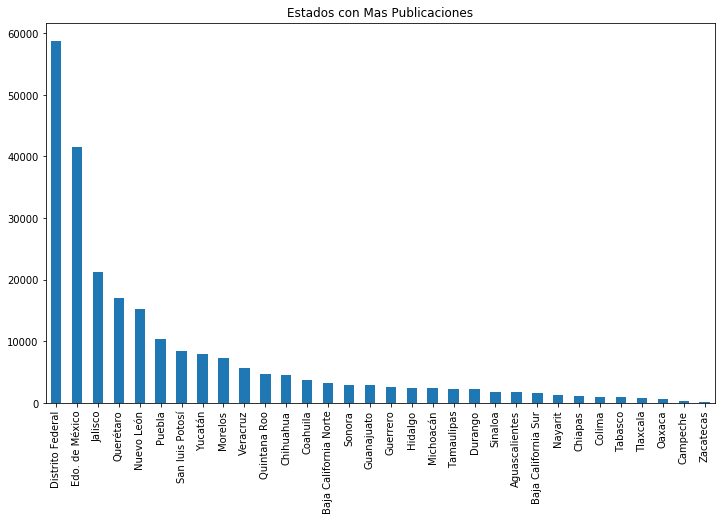

In [4]:
"CANTIDAD DE PUBLICACIONES POR ESTADO"

df['provincia'].value_counts().plot(kind='bar',figsize=(12,7),title='Estados con Mas Publicaciones')

Text(0.5, 1, 'Heatmap de Publicaciones Por Mes y Anio')

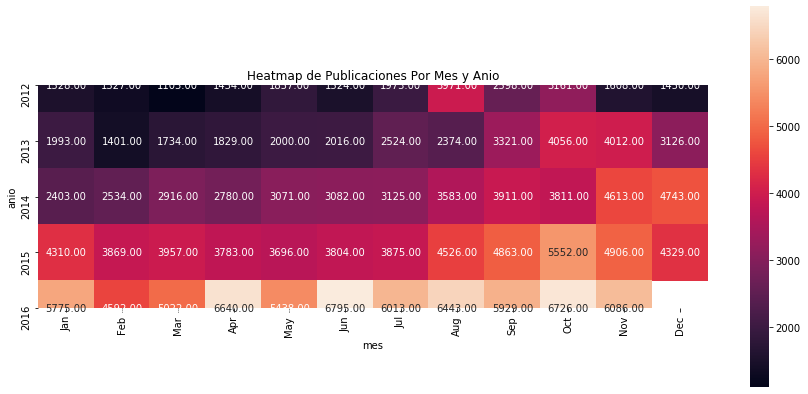

In [5]:
"HEATMAP CON TOTAL DE PUBLICACIONES POR MES Y ANIO"
import calendar
df2 = df.copy()
df2 = df2.loc[(df2['fecha'] < '2016-12')]
df2['anio'] = df2['fecha'].dt.year
df2['mes'] = df2['fecha'].dt.month
df2['aux'] = 1
listaDeMeses = list(calendar.month_abbr)
listaDeMeses.pop(0)
grupo = df2.groupby(['anio','mes'])['aux']
plt.figure(figsize=(15, 7))
g = sns.heatmap(grupo.count().unstack(), square=True, annot=True, fmt='.2f')
g.set_xticklabels(listaDeMeses,rotation=90);
g.set_title('Heatmap de Publicaciones Por Mes y Anio')

In [6]:
"ESTA CELDA ES NECESARIA PARA CUALQUIER MAPA, PARA PONER LOS NOMBRES DE LOS ESTADOS"
from shapely.geometry import Point

geoframeCiudades = gpd.read_file(cwd+"/mexCiudades")

diccCorreccionNombres = {'San luis Potosí':'San Luis Potosí','Edo. de México':'México','Baja California Norte':'Baja California' }

def corregirNombre(x):
    if x in diccCorreccionNombres.keys():
        return diccCorreccionNombres[x]
    return x

puntosACorregir = {'Baja California Sur':(-2.8,-0.1),'Sinaloa':(1,0),'Sinaloa':(1,0),'Chihuahua':(-1.5,0),'Coahuila':(-2,2),
                  'Nuevo Leon':(-0.5,0),'Sinaloa':(-1.5,0),'Durango':(-1.6,0.8),'Nayarit':(-0.7,0),'Jalisco':(-1.5,-0.5),
                   'Guanajuato':(-1,0),'Guerrero':(-1.9,-0.25),'Colima':(-2,-0.5),'Michoacan':(-2,-1),'Chiapas':(-0.25,-0.25)
                   ,'Tabasco':(-1,0),'Campeche':(-0.75,-0.75),'Quintana Roo':(-0.75,0),'Zacatecas':(-1.2,0.3),'Tamaulipas':(-1,1.6),
                   'Baja California':(-2.5,-4),'Mexico':(-0.8,-0.2),'Puebla':(-0.5,-0.75),'Guanajuato':(-1,-0.25),
                   'Queretaro':(0,-0.25),'Distrito Federal':(-0.7,-1),'Veracruz':(-0.25,0),'San Luis Potosi':(-0.2,0.2)
                   ,'Oaxaca':(-0.7,0)
                  }

def corregir(punto,tuplaXY):
    deltaX = tuplaXY[0]
    deltaY = tuplaXY[1]
    nuevoPunto = Point(punto.x+deltaX,punto.y+deltaY) 
    return nuevoPunto

def func(provincia, punto):
    if provincia in puntosACorregir.keys():
        return corregir(punto,puntosACorregir[provincia])
    return punto

geoframeCiudades['newGeometry'] = [func(geoframeCiudades.loc[idx, 'STATE_NAME'], geoframeCiudades.loc[idx, 'geometry'])
                                   for idx in range(len(geoframeCiudades))]

geoframeCiudadesCorregido = geoframeCiudades.drop('geometry',axis=1)
geoframeCiudadesCorregido.drop_duplicates(subset ="STATE_NAME", 
                     keep = 'first', inplace = True) 

estados_a_filtrar = ["Aguascalientes","Hidalgo","Tlaxcala","Morelos"]
def filtrar(x):
    return x not in estados_a_filtrar

geoframeCiudadesCorregido['aFiltrar'] = geoframeCiudades['STATE_NAME'].apply(filtrar)
geoframeC_C_Filtrado = geoframeCiudadesCorregido[geoframeCiudadesCorregido['aFiltrar']]
geoframeC_C_Filtrado.at[4,'STATE_NAME'] = 'DF'

In [7]:
"CANTIDAD DE PUBLICACIONES TOTALES POR ESTADO"
df3 = df.copy()
df3['aux'] = 1
df3_1 = df3.groupby('provincia')['aux'].count().reset_index()
df3_1['provincia'] = df3_1['provincia'].apply(corregirNombre) # Corrijo nombres de provincias para geoFrame

In [8]:
import geopandas as gpd
geoframe = gpd.read_file(cwd + "/mexEstados")
merge = geoframe.merge(df3_1,left_on='ESTADO',right_on='provincia')

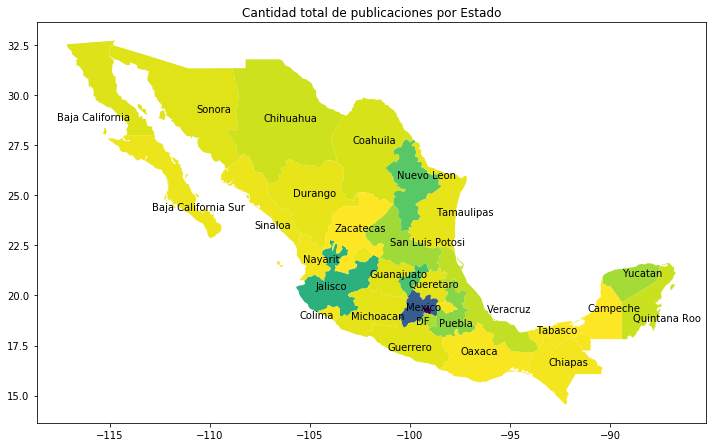

In [9]:
geoplot = merge.plot(figsize=(12,12),column='aux',cmap='viridis_r',legend=False)
geoplot.set_title("Cantidad total de publicaciones por Estado")
for locacion,label in zip(geoframeC_C_Filtrado.newGeometry, geoframeC_C_Filtrado.STATE_NAME):
    geoplot.annotate(label, xy=(locacion.x,locacion.y), xytext=(3, 3), textcoords="offset points")
plt.show()

In [10]:
"AUMENTO PROPORCIONAL DE LAS PUBLICACIONES POR ESTADO EN EL ULTIMO ANIO"

df4 = df.copy()
df4['anio'] = df4['fecha'].dt.year
df4['aux'] = 1
df4_1 = df4.groupby(['provincia','anio'])['aux'].count().unstack().reset_index()
df4_1['diferencia'] = df4_1[2016]/df4_1[2015]
df4_1.sort_values(by='diferencia',ascending=False);

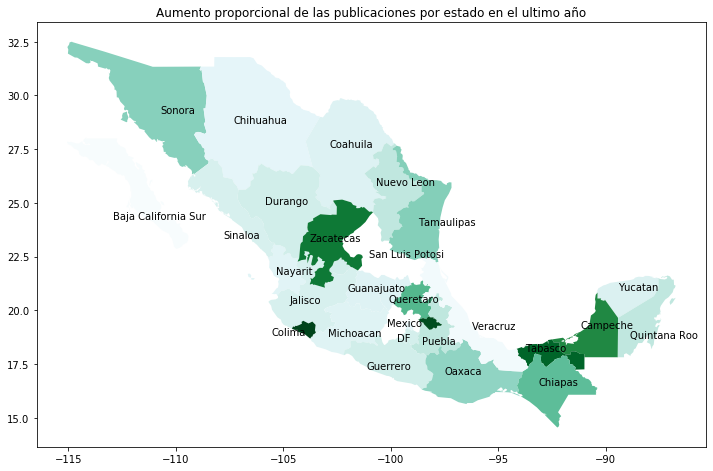

In [11]:
geoframe4 = gpd.read_file(cwd + "/mexEstados")
merge4 = geoframe4.merge(df4_1,left_on='ESTADO',right_on='provincia')

geoplot4 = merge4.plot(figsize=(12,12),column='diferencia',legend=False,cmap='BuGn')
geoplot4.set_title('Aumento proporcional de las publicaciones por estado en el ultimo año')
for locacion,label in zip(geoframeC_C_Filtrado.newGeometry, geoframeC_C_Filtrado.STATE_NAME):
    geoplot4.annotate(label, xy=(locacion.x,locacion.y), xytext=(3, 3), textcoords="offset points")
plt.show()

In [12]:
"10 PROVINCIAS DONDE MAS Y MENOS AUMENTARON PROPORCIONALMENTE LAS PUBLICACIONES EN EL ULTIMO ANIO"

df5 = df.copy()
df5['aux'] = 1
df5['año'] = df5['fecha'].dt.year
df5_1 = df5.groupby(['provincia','año'])['aux'].count().unstack().reset_index()
df5_1['proporcionAumento'] = df5_1[2016]/df5_1[2015]
df5_1 = df5_1[df5_1[2016]>300]

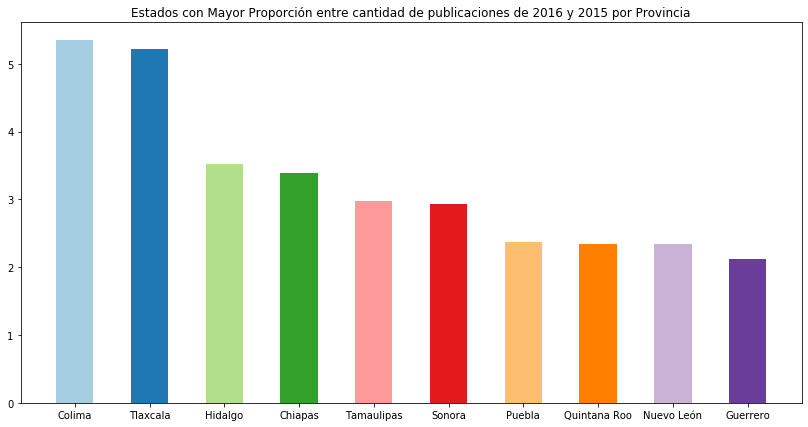

In [13]:
df5_2 = df5_1.sort_values(by='proporcionAumento',ascending=False)
df5_2Filtrado = df5_2[df5_2['proporcionAumento']>=2.12]

plt.figure(figsize=(14,7))
plt.title("Estados con Mayor Proporción entre cantidad de publicaciones de 2016 y 2015 por Provincia") 
plot = plt.bar(df5_2Filtrado["provincia"], df5_2Filtrado["proporcionAumento"], color=plt.cm.Paired(np.arange(len(df5_2Filtrado))),width=0.5)

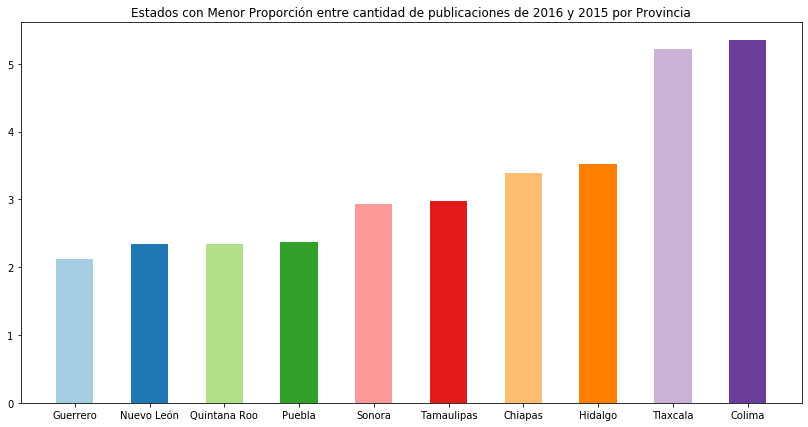

In [14]:
df5_3 = df5_1.sort_values(by='proporcionAumento',ascending=True)
df5_3Filtrado = df5_3[df5_3['proporcionAumento']>=2.12]

plt.figure(figsize=(14,7))
plt.title("Estados con Menor Proporción entre cantidad de publicaciones de 2016 y 2015 por Provincia") 
plot = plt.bar(df5_3Filtrado["provincia"], df5_3Filtrado["proporcionAumento"], color=plt.cm.Paired(np.arange(len(df5_3Filtrado))),width=0.5)

In [15]:
"TIPO DE PROPIEDAD MAS PUBLICADO POR ESTADO"

df6 = df.copy()
df6['aux'] = 1
df6_1 = df6.groupby(['provincia','tipodepropiedad'])['aux'].count().reset_index()

In [16]:
df6_2 = df6_1.loc[df6_1.groupby('provincia')['aux'].idxmax()]
df6_2['provincia'] = df6_2['provincia'].apply(corregirNombre)
merge6 = geoframe.merge(df6_2,left_on='ESTADO',right_on='provincia')

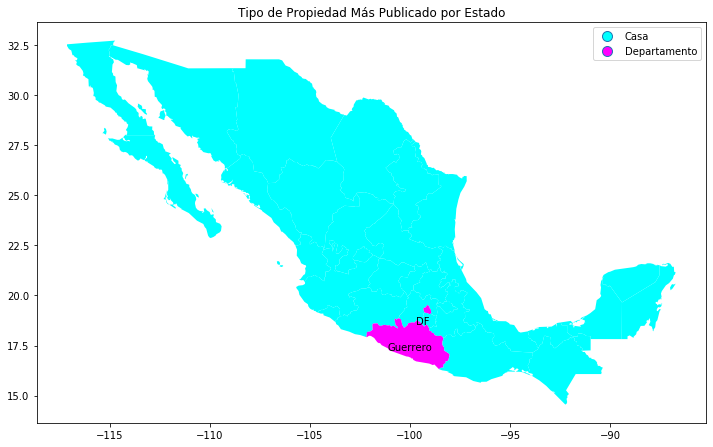

In [17]:
geoplot6 = merge6.plot(figsize=(12,12),column='tipodepropiedad',legend=True,cmap='cool')
geoplot6.set_title('Tipo de Propiedad Más Publicado por Estado')
for locacion,label in zip(geoframeC_C_Filtrado.newGeometry, geoframeC_C_Filtrado.STATE_NAME):
    if label == 'DF' or label == 'Guerrero':
        geoplot6.annotate(label, xy=(locacion.x,locacion.y), xytext=(3, 3), textcoords="offset points")
plt.show()

In [26]:
"PUBLICACIONES A LO LARGO DEL TIEMPO"

df7 = pd.read_csv(cwd+"/train.csv")

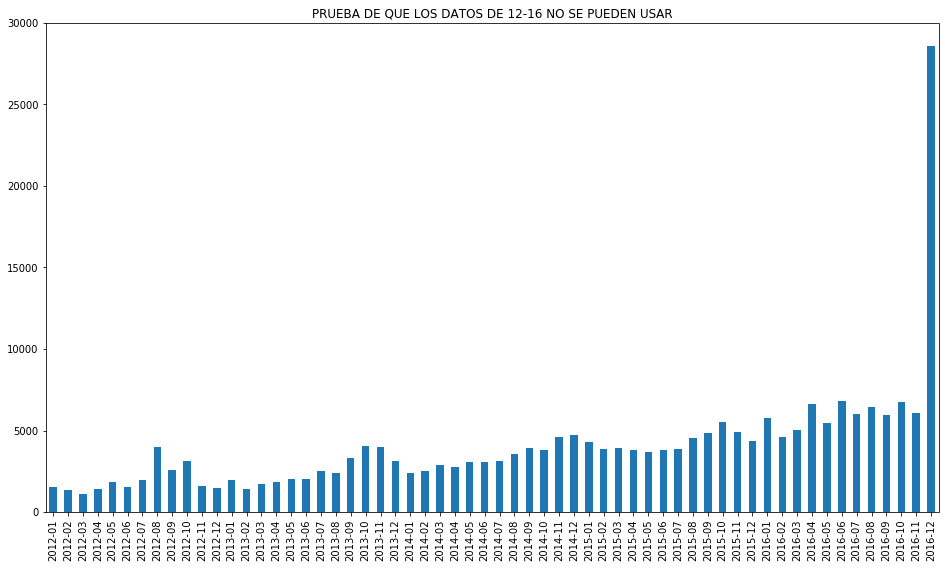

In [27]:
df8 = df7.copy()
df8.fecha = df8.fecha.apply(lambda fecha: fecha[:-12])
df8.fecha.value_counts().sort_index().plot(kind='bar',title='PRUEBA DE QUE LOS DATOS DE 12-16 NO SE PUEDEN USAR',figsize=(16,9))

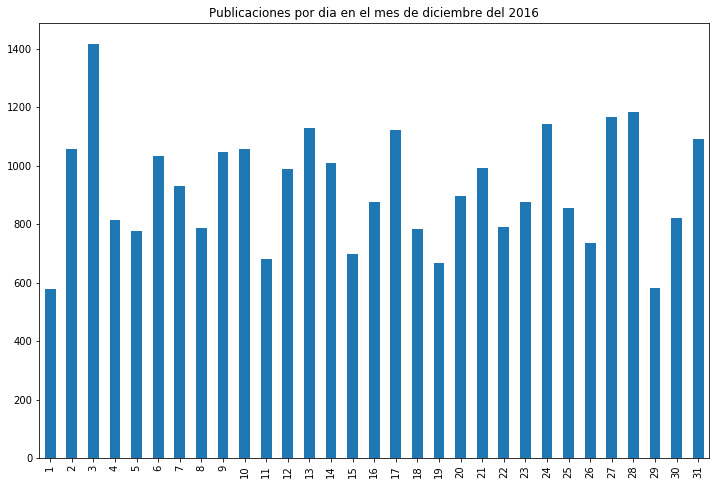

In [30]:
df9 = df7.copy()
df9["fecha"] = pd.to_datetime(df9["fecha"])
diciembre_2016 = df9.loc[(df9["fecha"].dt.year == 2016) & (df9["fecha"].dt.month == 12)]
diciembre_2016.fecha.dt.day.value_counts().sort_index().plot(figsize = (12,8), kind='bar', title='Publicaciones por dia en el mes de diciembre del 2016')

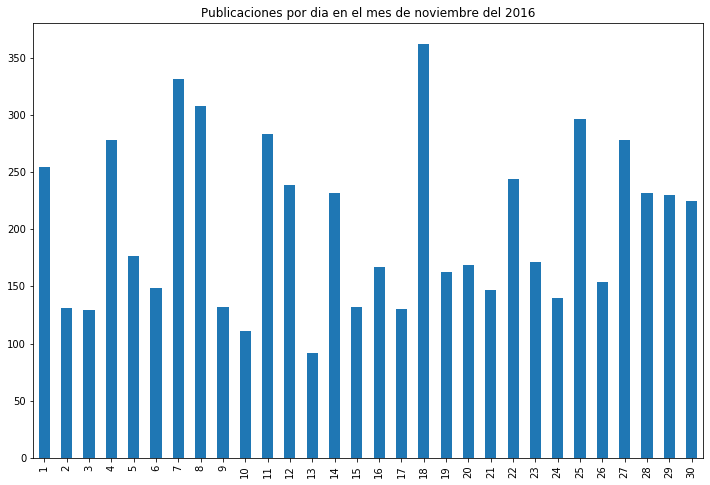

In [32]:
noviembre_2016 = df9.loc[(df9["fecha"].dt.year == 2016) & (df9["fecha"].dt.month == 11)]
noviembre_2016["fecha"].dt.day.value_counts().sort_index().plot(figsize = (12,8), kind = 'bar', title='Publicaciones por dia en el mes de noviembre del 2016')

Text(0.5, 1.0, 'Cantidad de propiedades publicadas por año en diciembre y noviembre')

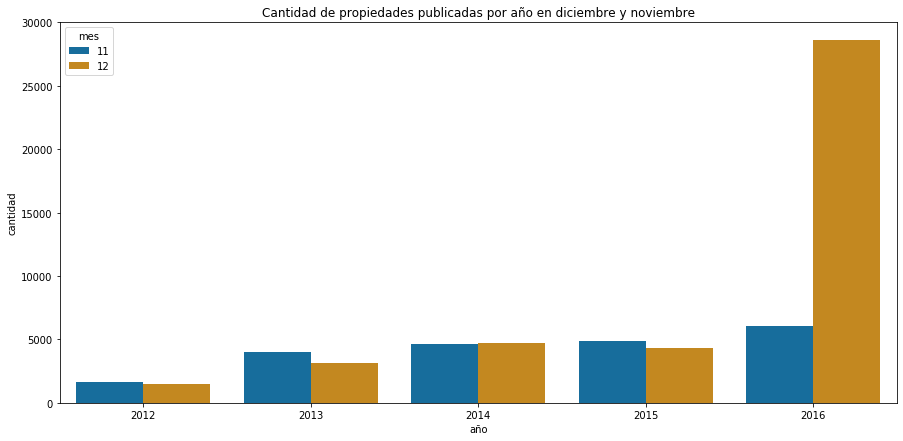

In [33]:
df10 = df7.copy()
df10['cantidad'] = 1
df10.fecha = pd.to_datetime(df10.fecha)
df10['mes'] = df10.fecha.dt.month
df10['año'] = df10.fecha.dt.year
df10 = df10.loc[df10.mes >= 11]
df10 = df10.groupby(['año', 'mes']).agg({'cantidad':sum}).reset_index()
plt.figure(figsize=(15, 7))
sns.barplot(x="año",y="cantidad", hue="mes", data=df10, palette="colorblind").set_title('Cantidad de propiedades publicadas por año en diciembre y noviembre')